# Ungraded Lab: Predicting Sunspots with Neural Networks

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

2024-10-04 18:54:40.260702: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 18:54:40.263830: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 18:54:40.314843: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 18:54:41.098463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [3]:
# Download the Dataset
# !wget -nc https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

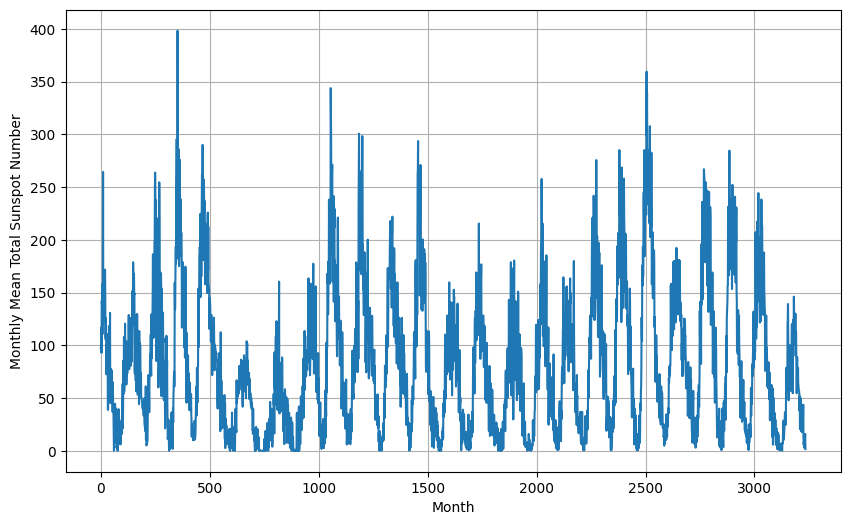

In [4]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [5]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

As mentioned in the lectures, if your results don't look good, you can try tweaking the parameters here and see if the model will learn better.

In [7]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You've seen these layers before and here is how it looks like when combined.

In [8]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [9]:
# Get initial weights
init_weights = model.get_weights()

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 39.6056 - learning_rate: 1.0000e-08
Epoch 2/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 37.5709

2024-10-04 18:54:46.767140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/osboxes/anaconda3/envs/tf/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 35.4149 - learning_rate: 1.1220e-08
Epoch 3/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 35.2212

2024-10-04 18:54:48.197212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 33.3105 - learning_rate: 1.2589e-08
Epoch 4/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 33.5615

2024-10-04 18:54:49.633158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 31.8866 - learning_rate: 1.4125e-08
Epoch 5/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 32.3938

2024-10-04 18:54:51.102964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 30.7491 - learning_rate: 1.5849e-08
Epoch 6/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 31.0556

2024-10-04 18:54:52.562580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 29.5846 - learning_rate: 1.7783e-08
Epoch 7/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 30.2958

2024-10-04 18:54:53.928216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 28.8373 - learning_rate: 1.9953e-08
Epoch 8/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 29.6242

2024-10-04 18:54:55.276603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 28.2574 - learning_rate: 2.2387e-08
Epoch 9/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 29.0306

2024-10-04 18:54:56.705709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 27.7058 - learning_rate: 2.5119e-08
Epoch 10/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 28.5875

2024-10-04 18:54:58.127009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 27.1406 - learning_rate: 2.8184e-08
Epoch 11/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 28.4354

2024-10-04 18:55:00.259840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 26.5865 - learning_rate: 3.1623e-08
Epoch 12/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 27.5116

2024-10-04 18:55:02.224839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 26.0124 - learning_rate: 3.5481e-08
Epoch 13/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 27.1473

2024-10-04 18:55:03.969990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 25.3794 - learning_rate: 3.9811e-08
Epoch 14/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 26.4048

2024-10-04 18:55:05.656388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 24.5832 - learning_rate: 4.4668e-08
Epoch 15/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 25.1800

2024-10-04 18:55:07.439350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 23.9747 - learning_rate: 5.0119e-08
Epoch 16/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 23.6574

2024-10-04 18:55:09.075827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 23.4656 - learning_rate: 5.6234e-08
Epoch 17/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 22.1840

2024-10-04 18:55:11.110552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 22.3987 - learning_rate: 6.3096e-08
Epoch 18/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 21.4732

2024-10-04 18:55:12.704429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 21.7260 - learning_rate: 7.0795e-08
Epoch 19/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 21.4802

2024-10-04 18:55:14.418310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 21.4920 - learning_rate: 7.9433e-08
Epoch 20/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.7815

2024-10-04 18:55:16.089725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 21.3023 - learning_rate: 8.9125e-08
Epoch 21/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 20.6773

2024-10-04 18:55:17.734573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 21.4410 - learning_rate: 1.0000e-07
Epoch 22/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.3056

2024-10-04 18:55:19.298233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 20.6177 - learning_rate: 1.1220e-07
Epoch 23/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 19.7080

2024-10-04 18:55:20.891886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 20.3663 - learning_rate: 1.2589e-07
Epoch 24/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 19.2904

2024-10-04 18:55:22.410919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 20.0875 - learning_rate: 1.4125e-07
Epoch 25/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 19.7194

2024-10-04 18:55:23.957253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.9333 - learning_rate: 1.5849e-07
Epoch 26/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 19.5167

2024-10-04 18:55:25.617833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.9579 - learning_rate: 1.7783e-07
Epoch 27/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18.6695

2024-10-04 18:55:27.177031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.3257 - learning_rate: 1.9953e-07
Epoch 28/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18.3744

2024-10-04 18:55:28.786567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.3081 - learning_rate: 2.2387e-07
Epoch 29/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 18.5774

2024-10-04 18:55:30.418495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.2462 - learning_rate: 2.5119e-07
Epoch 30/100


2024-10-04 18:55:32.084575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.9850 - learning_rate: 2.8184e-07
Epoch 31/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 17.9511

2024-10-04 18:55:34.513989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 18.9997 - learning_rate: 3.1623e-07
Epoch 32/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17.9995

2024-10-04 18:55:36.212069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.8831 - learning_rate: 3.5481e-07
Epoch 33/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 17.7047

2024-10-04 18:55:37.757597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.6248 - learning_rate: 3.9811e-07
Epoch 34/100


2024-10-04 18:55:39.392364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 19.0865 - learning_rate: 4.4668e-07
Epoch 35/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 18.7166

2024-10-04 18:55:41.910218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.0983 - learning_rate: 5.0119e-07
Epoch 36/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.9087

2024-10-04 18:55:43.601415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 18.5080 - learning_rate: 5.6234e-07
Epoch 37/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 17.9046

2024-10-04 18:55:45.243617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.5149 - learning_rate: 6.3096e-07
Epoch 38/100


2024-10-04 18:55:46.838659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 18.4403 - learning_rate: 7.0795e-07
Epoch 39/100


2024-10-04 18:55:49.391299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 18.8849 - learning_rate: 7.9433e-07
Epoch 40/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 18.9461

2024-10-04 18:55:51.912854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 18.6410 - learning_rate: 8.9125e-07
Epoch 41/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 18.6378

2024-10-04 18:55:53.424248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 18.6647 - learning_rate: 1.0000e-06
Epoch 42/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.2025

2024-10-04 18:55:55.078687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.0801 - learning_rate: 1.1220e-06
Epoch 43/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 19.1176

2024-10-04 18:55:56.628472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.6968 - learning_rate: 1.2589e-06
Epoch 44/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.4675

2024-10-04 18:55:58.199213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 18.0270 - learning_rate: 1.4125e-06
Epoch 45/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 18.0002

2024-10-04 18:55:59.712259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 18.3585 - learning_rate: 1.5849e-06
Epoch 46/100


2024-10-04 18:56:01.384524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 18.5861 - learning_rate: 1.7783e-06
Epoch 47/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 17.7930

2024-10-04 18:56:03.717250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 18.4837 - learning_rate: 1.9953e-06
Epoch 48/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 19.5157

2024-10-04 18:56:05.141370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 18.7042 - learning_rate: 2.2387e-06
Epoch 49/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 19.6107

2024-10-04 18:56:07.185102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.8105 - learning_rate: 2.5119e-06
Epoch 50/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18.7840

2024-10-04 18:56:08.745751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 18.5684 - learning_rate: 2.8184e-06
Epoch 51/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 18.2382

2024-10-04 18:56:10.491017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 18.7314 - learning_rate: 3.1623e-06
Epoch 52/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17.4101

2024-10-04 18:56:12.193009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 18.8508 - learning_rate: 3.5481e-06
Epoch 53/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 20.5950

2024-10-04 18:56:13.845523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.3269 - learning_rate: 3.9811e-06
Epoch 54/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 19.7506

2024-10-04 18:56:15.535028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.1034 - learning_rate: 4.4668e-06
Epoch 55/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 21.5228

2024-10-04 18:56:17.212794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.0888 - learning_rate: 5.0119e-06
Epoch 56/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 18.5577

2024-10-04 18:56:18.882655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.6490 - learning_rate: 5.6234e-06
Epoch 57/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.5146

2024-10-04 18:56:20.449782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 18.9498 - learning_rate: 6.3096e-06
Epoch 58/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.0775

2024-10-04 18:56:22.125308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.0770 - learning_rate: 7.0795e-06
Epoch 59/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.8171

2024-10-04 18:56:23.748303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.1487 - learning_rate: 7.9433e-06
Epoch 60/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.8162

2024-10-04 18:56:25.357640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.2237 - learning_rate: 8.9125e-06
Epoch 61/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 16.8223

2024-10-04 18:56:26.924540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.2281 - learning_rate: 1.0000e-05
Epoch 62/100


2024-10-04 18:56:28.623274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.2628 - learning_rate: 1.1220e-05
Epoch 63/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 18.3517

2024-10-04 18:56:31.116866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 19.4126 - learning_rate: 1.2589e-05
Epoch 64/100


2024-10-04 18:56:32.862762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.7412 - learning_rate: 1.4125e-05
Epoch 65/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 19.7206

2024-10-04 18:56:35.277427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.3684 - learning_rate: 1.5849e-05
Epoch 66/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18.0825

2024-10-04 18:56:36.960230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.2783 - learning_rate: 1.7783e-05
Epoch 67/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17.8124

2024-10-04 18:56:38.543215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 19.6697 - learning_rate: 1.9953e-05
Epoch 68/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 17.5207

2024-10-04 18:56:40.243557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 19.5268 - learning_rate: 2.2387e-05
Epoch 69/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 18.5121

2024-10-04 18:56:42.263929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.9714 - learning_rate: 2.5119e-05
Epoch 70/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 21.7938

2024-10-04 18:56:43.857826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 22.9240 - learning_rate: 2.8184e-05
Epoch 71/100


2024-10-04 18:56:45.552501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 20.1148 - learning_rate: 3.1623e-05
Epoch 72/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18.3029

2024-10-04 18:56:48.109096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.4272 - learning_rate: 3.5481e-05
Epoch 73/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 17.8805

2024-10-04 18:56:49.607050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 19.6131 - learning_rate: 3.9811e-05
Epoch 74/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 20.7429

2024-10-04 18:56:51.001832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.8753 - learning_rate: 4.4668e-05
Epoch 75/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 22.0381

2024-10-04 18:56:52.460007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 25.6739 - learning_rate: 5.0119e-05
Epoch 76/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19.5981

2024-10-04 18:56:53.825033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 21.0579 - learning_rate: 5.6234e-05
Epoch 77/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19.9951

2024-10-04 18:56:55.217567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 20.7342 - learning_rate: 6.3096e-05
Epoch 78/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 23.6553

2024-10-04 18:56:56.582669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 24.0775 - learning_rate: 7.0795e-05
Epoch 79/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19.1970

2024-10-04 18:56:58.080300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 21.6766 - learning_rate: 7.9433e-05
Epoch 80/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19.4269

2024-10-04 18:56:59.554202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 22.0459 - learning_rate: 8.9125e-05
Epoch 81/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 23.0133

2024-10-04 18:57:00.930328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 22.0816 - learning_rate: 1.0000e-04
Epoch 82/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 22.1565

2024-10-04 18:57:02.452995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 22.3234 - learning_rate: 1.1220e-04
Epoch 83/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 19.5420

2024-10-04 18:57:03.857063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 22.5898 - learning_rate: 1.2589e-04
Epoch 84/100


2024-10-04 18:57:05.263877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 23.8037 - learning_rate: 1.4125e-04
Epoch 85/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 24.5022

2024-10-04 18:57:07.890910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 27.4931 - learning_rate: 1.5849e-04
Epoch 86/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 25.9226

2024-10-04 18:57:09.270269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 24.7887 - learning_rate: 1.7783e-04
Epoch 87/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 26.2883

2024-10-04 18:57:10.702178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 26.6908 - learning_rate: 1.9953e-04
Epoch 88/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 31.9926

2024-10-04 18:57:12.063683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 40.3641 - learning_rate: 2.2387e-04
Epoch 89/100


2024-10-04 18:57:13.444235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 44.8777 - learning_rate: 2.5119e-04
Epoch 90/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 34.5180

2024-10-04 18:57:16.021115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 37.0363 - learning_rate: 2.8184e-04
Epoch 91/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 45.7177

2024-10-04 18:57:17.455196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 42.0373 - learning_rate: 3.1623e-04
Epoch 92/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 56.4050

2024-10-04 18:57:19.021545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 56.9647 - learning_rate: 3.5481e-04
Epoch 93/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 54.4056

2024-10-04 18:57:20.563511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 54.5166 - learning_rate: 3.9811e-04
Epoch 94/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 55.0677

2024-10-04 18:57:22.155778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 57.9063 - learning_rate: 4.4668e-04
Epoch 95/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 66.0291

2024-10-04 18:57:23.660591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 59.7632 - learning_rate: 5.0119e-04
Epoch 96/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 71.4823

2024-10-04 18:57:25.275277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 70.5061 - learning_rate: 5.6234e-04
Epoch 97/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 60.8186

2024-10-04 18:57:26.830908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 61.9373 - learning_rate: 6.3096e-04
Epoch 98/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 55.9581

2024-10-04 18:57:28.440009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 61.7774 - learning_rate: 7.0795e-04
Epoch 99/100


2024-10-04 18:57:30.102406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 69.4191 - learning_rate: 7.9433e-04
Epoch 100/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 61.3071

2024-10-04 18:57:32.626023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 64.4769 - learning_rate: 8.9125e-04


2024-10-04 18:57:34.217286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-08, 0.001, 0.0, 100.0)

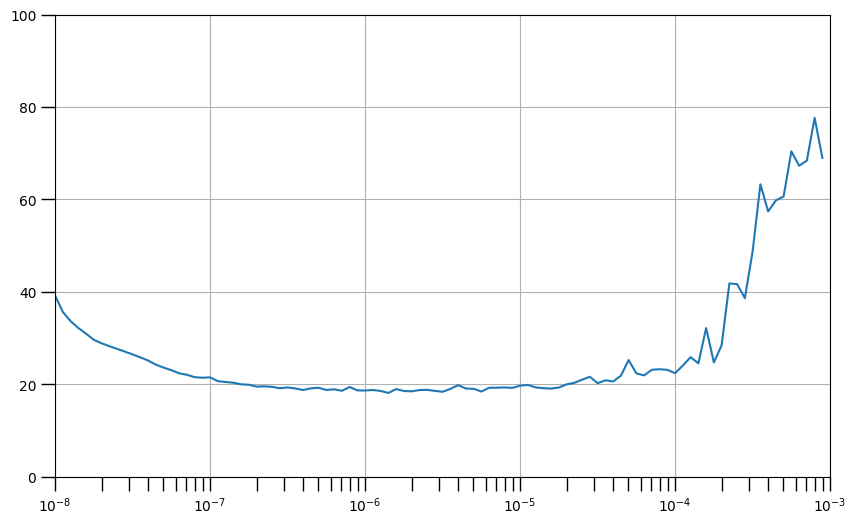

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [13]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 32.2209 - mae: 32.7146
Epoch 2/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 24.5328 - mae: 25.0280

2024-10-04 18:57:39.042449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 23.1207 - mae: 23.6150
Epoch 3/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.2002 - mae: 20.6965

2024-10-04 18:57:40.612177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 20.6727 - mae: 21.1674
Epoch 4/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 19.6338 - mae: 20.1301

2024-10-04 18:57:42.339106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 19.6808 - mae: 20.1741
Epoch 5/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 18.5853 - mae: 19.0822

2024-10-04 18:57:43.940525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.9948 - mae: 19.4884
Epoch 6/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 18.4032 - mae: 18.8961

2024-10-04 18:57:45.563890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 19.0418 - mae: 19.5340
Epoch 7/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 17.7505 - mae: 18.2446

2024-10-04 18:57:47.109105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.3216 - mae: 18.8145
Epoch 8/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.5054 - mae: 17.9995

2024-10-04 18:57:48.723723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 18.1924 - mae: 18.6850
Epoch 9/100


2024-10-04 18:57:50.256736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 18.1941 - mae: 18.6859
Epoch 10/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 18.1737 - mae: 18.6635

2024-10-04 18:57:52.865524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.3764 - mae: 18.8682
Epoch 11/100


2024-10-04 18:57:54.437420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 18.3136 - mae: 18.8056
Epoch 12/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18.0927 - mae: 18.5806

2024-10-04 18:57:57.080441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 18.1709 - mae: 18.6621
Epoch 13/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17.5641 - mae: 18.0582

2024-10-04 18:57:58.695597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.7931 - mae: 18.2853
Epoch 14/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 17.8053 - mae: 18.2996

2024-10-04 18:58:00.280793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.9622 - mae: 18.4548
Epoch 15/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 18.0915 - mae: 18.5753

2024-10-04 18:58:01.926013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.8267 - mae: 18.3165
Epoch 16/100
 6/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 17.0045 - mae: 17.4930

2024-10-04 18:58:03.514393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.4186 - mae: 17.9079
Epoch 17/100


2024-10-04 18:58:05.076116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 17.6582 - mae: 18.1479
Epoch 18/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17.3570 - mae: 17.8421

2024-10-04 18:58:07.641057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.5245 - mae: 18.0136
Epoch 19/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17.0838 - mae: 17.5728

2024-10-04 18:58:09.277358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.4404 - mae: 17.9307
Epoch 20/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 17.8877 - mae: 18.3747

2024-10-04 18:58:10.927590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.5923 - mae: 18.0833
Epoch 21/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.7752 - mae: 17.2627

2024-10-04 18:58:12.507018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.3001 - mae: 17.7906
Epoch 22/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.7280 - mae: 17.2163

2024-10-04 18:58:14.019207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.2453 - mae: 17.7355
Epoch 23/100
 4/93 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 16.6359 - mae: 17.1300

2024-10-04 18:58:15.556522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.2028 - mae: 17.6945
Epoch 24/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.8140 - mae: 17.3018

2024-10-04 18:58:17.176556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.2984 - mae: 17.7887
Epoch 25/100


2024-10-04 18:58:18.690737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 17.2392 - mae: 17.7292
Epoch 26/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.4974 - mae: 16.9851

2024-10-04 18:58:21.373430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.2065 - mae: 17.6972
Epoch 27/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.7695 - mae: 17.2562

2024-10-04 18:58:22.923489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.1658 - mae: 17.6544
Epoch 28/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.4651 - mae: 16.9586

2024-10-04 18:58:24.556226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.0308 - mae: 17.5218
Epoch 29/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.6483 - mae: 17.1375

2024-10-04 18:58:26.196878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.2506 - mae: 17.7404
Epoch 30/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.3771 - mae: 16.8670

2024-10-04 18:58:27.879144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.3745 - mae: 17.8642
Epoch 31/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.3691 - mae: 16.8619

2024-10-04 18:58:29.444471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.1101 - mae: 17.6015
Epoch 32/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 16.2147 - mae: 16.6931

2024-10-04 18:58:30.975218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.0544 - mae: 17.5407
Epoch 33/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.4502 - mae: 16.9350

2024-10-04 18:58:32.586567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.1125 - mae: 17.6008
Epoch 34/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.4270 - mae: 16.9113

2024-10-04 18:58:34.093452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.0587 - mae: 17.5476
Epoch 35/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.1039 - mae: 16.5946

2024-10-04 18:58:35.711242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9675 - mae: 17.4568
Epoch 36/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.2255 - mae: 16.7129

2024-10-04 18:58:37.257717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9519 - mae: 17.4412
Epoch 37/100


2024-10-04 18:58:38.890765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.0179 - mae: 17.5071
Epoch 38/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 16.2458 - mae: 16.7361

2024-10-04 18:58:41.356155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9626 - mae: 17.4524
Epoch 39/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.3553 - mae: 16.8389

2024-10-04 18:58:42.943330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9432 - mae: 17.4314
Epoch 40/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.2368 - mae: 16.7243

2024-10-04 18:58:44.538151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.8922 - mae: 17.3813
Epoch 41/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.2160 - mae: 16.7075

2024-10-04 18:58:46.093096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9032 - mae: 17.3940
Epoch 42/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.2694 - mae: 16.7586

2024-10-04 18:58:47.717263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9392 - mae: 17.4284
Epoch 43/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.4431 - mae: 16.9351

2024-10-04 18:58:49.283091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 16.9391 - mae: 17.4286
Epoch 44/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.1788 - mae: 16.6699

2024-10-04 18:58:51.012016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.8942 - mae: 17.3842
Epoch 45/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.6371 - mae: 17.1304

2024-10-04 18:58:52.555129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.0034 - mae: 17.4944
Epoch 46/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.4582 - mae: 16.9537

2024-10-04 18:58:54.152249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9348 - mae: 17.4268
Epoch 47/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.6009 - mae: 17.0971

2024-10-04 18:58:55.733540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9281 - mae: 17.4198
Epoch 48/100
 6/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 16.1920 - mae: 16.6818

2024-10-04 18:58:57.296050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.8770 - mae: 17.3658
Epoch 49/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 16.4962 - mae: 16.9891

2024-10-04 18:58:58.935855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9404 - mae: 17.4310
Epoch 50/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.4920 - mae: 16.9798

2024-10-04 18:59:00.506093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9029 - mae: 17.3906
Epoch 51/100


2024-10-04 18:59:02.082780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 16.8781 - mae: 17.3681
Epoch 52/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.5656 - mae: 17.0612

2024-10-04 18:59:04.584747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 16.8786 - mae: 17.3689
Epoch 53/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 16.5219 - mae: 17.0126

2024-10-04 18:59:06.118023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 16.9110 - mae: 17.4011
Epoch 54/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.4881 - mae: 16.9792

2024-10-04 18:59:07.785038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 16.9114 - mae: 17.4015
Epoch 55/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.5763 - mae: 17.0660

2024-10-04 18:59:09.416459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 16.8767 - mae: 17.3657
Epoch 56/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.4637 - mae: 16.9536

2024-10-04 18:59:11.087570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.8587 - mae: 17.3479
Epoch 57/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.5387 - mae: 17.0285

2024-10-04 18:59:12.553872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 16.9847 - mae: 17.4738
Epoch 58/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 16.2655 - mae: 16.7593

2024-10-04 18:59:14.158182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 16.8185 - mae: 17.3080
Epoch 59/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.2980 - mae: 16.7875

2024-10-04 18:59:15.835831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 16.8193 - mae: 17.3082
Epoch 60/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 16.8990 - mae: 17.3915

2024-10-04 18:59:17.531551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.0433 - mae: 17.5342
Epoch 61/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 16.8047 - mae: 17.2966

2024-10-04 18:59:19.060814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 17.1295 - mae: 17.6200
Epoch 62/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 17.2054 - mae: 17.6919

2024-10-04 18:59:20.422822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.4583 - mae: 17.9474
Epoch 63/100


2024-10-04 18:59:21.947714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 17.4385 - mae: 17.9271
Epoch 64/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.6661 - mae: 17.1559

2024-10-04 18:59:24.384540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.2478 - mae: 17.7374
Epoch 65/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.9219 - mae: 17.4125

2024-10-04 18:59:25.854850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.4607 - mae: 17.9510
Epoch 66/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 17.0076 - mae: 17.4987

2024-10-04 18:59:27.385132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.4917 - mae: 17.9832
Epoch 67/100


2024-10-04 18:59:28.847737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 17.2239 - mae: 17.7113
Epoch 68/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.0053 - mae: 17.4953

2024-10-04 18:59:31.300756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.2326 - mae: 17.7212
Epoch 69/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.7993 - mae: 17.2914

2024-10-04 18:59:32.650870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.1602 - mae: 17.6495
Epoch 70/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.7841 - mae: 17.2722

2024-10-04 18:59:34.289018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.2280 - mae: 17.7169
Epoch 71/100


2024-10-04 18:59:35.802237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 17.1711 - mae: 17.6597
Epoch 72/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.5615 - mae: 17.0520

2024-10-04 18:59:38.495710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.2273 - mae: 17.7161
Epoch 73/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.4770 - mae: 16.9663

2024-10-04 18:59:40.144829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.1258 - mae: 17.6154
Epoch 74/100


2024-10-04 18:59:41.645391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 17.1846 - mae: 17.6731
Epoch 75/100


2024-10-04 18:59:44.322358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.1356 - mae: 17.6250
Epoch 76/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.4137 - mae: 16.9005

2024-10-04 18:59:46.765985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.1635 - mae: 17.6524
Epoch 77/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.0892 - mae: 16.5795

2024-10-04 18:59:48.378197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.0150 - mae: 17.5050
Epoch 78/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.4888 - mae: 16.9792

2024-10-04 18:59:49.884829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.1047 - mae: 17.5946
Epoch 79/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.6207 - mae: 17.1094

2024-10-04 18:59:51.542281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.2351 - mae: 17.7239
Epoch 80/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 16.0739 - mae: 16.5604

2024-10-04 18:59:53.159553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 17.1770 - mae: 17.6648
Epoch 81/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 16.5161 - mae: 16.9996

2024-10-04 18:59:54.909439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.2824 - mae: 17.7695
Epoch 82/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.2872 - mae: 16.7713

2024-10-04 18:59:56.515516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.0958 - mae: 17.5840
Epoch 83/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 16.4571 - mae: 16.9437

2024-10-04 18:59:58.188933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.2260 - mae: 17.7135
Epoch 84/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17.0201 - mae: 17.5068

2024-10-04 18:59:59.807749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.3200 - mae: 17.8078
Epoch 85/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.8494 - mae: 17.3357

2024-10-04 19:00:01.353787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.3481 - mae: 17.8376
Epoch 86/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.5891 - mae: 17.0720

2024-10-04 19:00:03.052357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.4088 - mae: 17.8963
Epoch 87/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.6235 - mae: 17.1069

2024-10-04 19:00:04.618135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 17.3544 - mae: 17.8408
Epoch 88/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.8005 - mae: 17.2869

2024-10-04 19:00:06.395640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.3505 - mae: 17.8385
Epoch 89/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 16.7145 - mae: 17.2026

2024-10-04 19:00:07.939808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.2137 - mae: 17.7025
Epoch 90/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.8095 - mae: 17.2973

2024-10-04 19:00:09.642926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.1865 - mae: 17.6743
Epoch 91/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.8833 - mae: 17.3713

2024-10-04 19:00:11.211035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.4029 - mae: 17.8921
Epoch 92/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 16.7228 - mae: 17.2088

2024-10-04 19:00:12.712954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.3904 - mae: 17.8776
Epoch 93/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 16.5633 - mae: 17.0444

2024-10-04 19:00:14.373572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.1185 - mae: 17.6041
Epoch 94/100


2024-10-04 19:00:15.922925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 17.1754 - mae: 17.6625
Epoch 95/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.9640 - mae: 17.4508

2024-10-04 19:00:18.646503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 17.1933 - mae: 17.6802
Epoch 96/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.9629 - mae: 17.4500

2024-10-04 19:00:20.182021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.2261 - mae: 17.7129
Epoch 97/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.6988 - mae: 17.1871

2024-10-04 19:00:21.771469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.1917 - mae: 17.6782
Epoch 98/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.8554 - mae: 17.3419

2024-10-04 19:00:23.349261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 17.2378 - mae: 17.7245
Epoch 99/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 16.6690 - mae: 17.1530

2024-10-04 19:00:25.041780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 17.1692 - mae: 17.6557
Epoch 100/100


2024-10-04 19:00:26.602412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 17.2599 - mae: 17.7464


2024-10-04 19:00:29.383130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


You can visualize the training and see if the loss and MAE are still trending down.

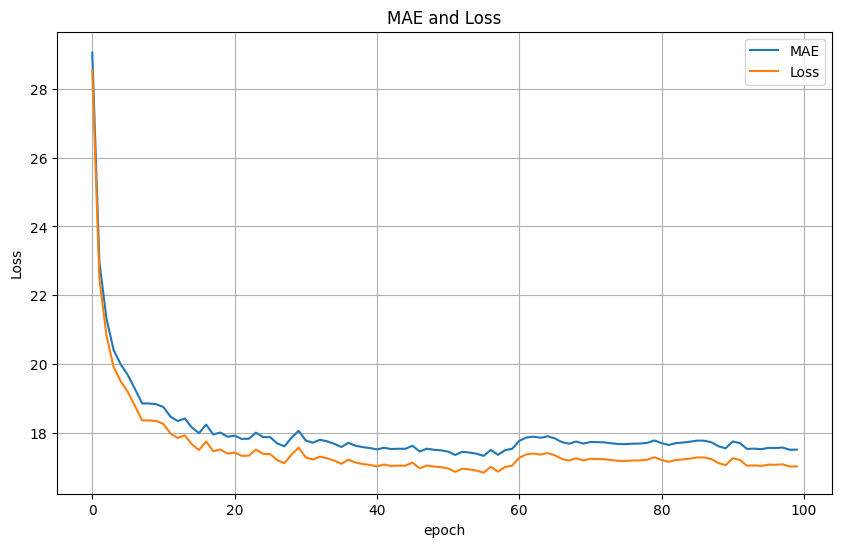

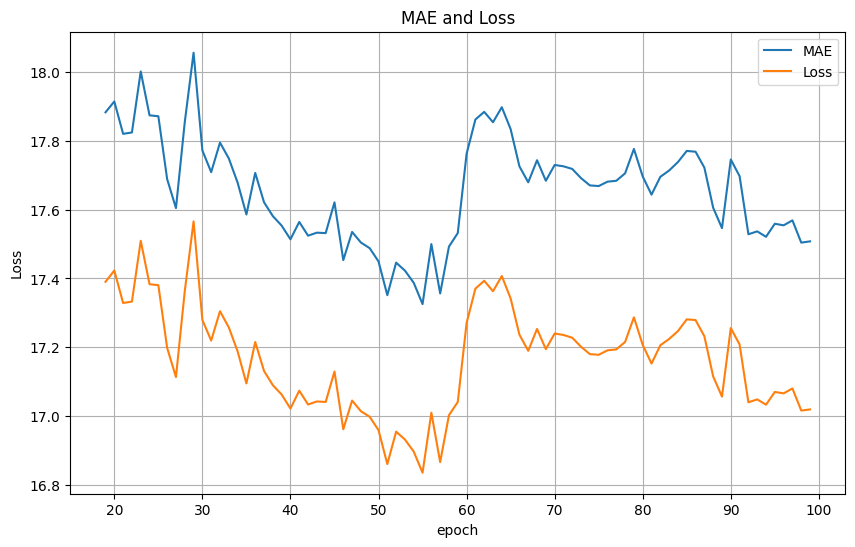

In [15]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

2024-10-04 19:00:30.340183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


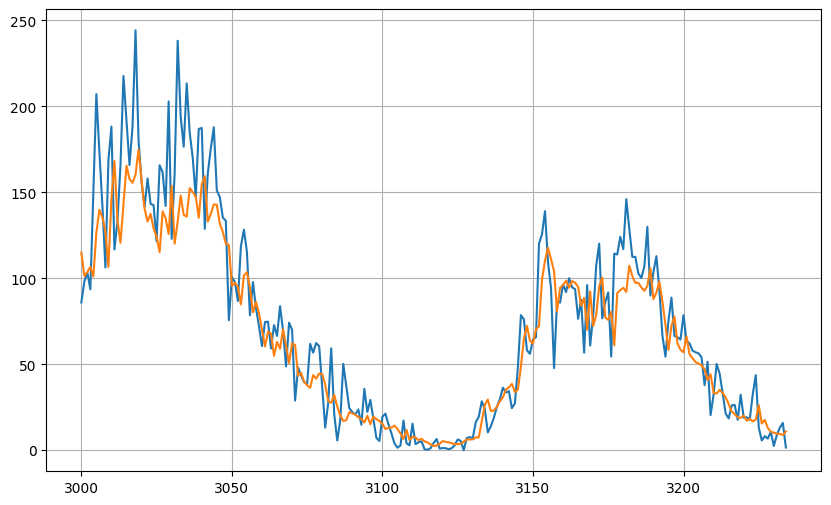

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [18]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

15.633592


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!